In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.advect1d import Advect1D

In [2]:
def init_shape(x, x0=15, shape="step"):
    if shape == "gaussian":
        std = 4
        return np.exp(-pow((x-x0)/std, 2)/2)

    #step
    out = np.ones_like(x)
    out[x<x0-10] = 0
    out[x>x0+10] = 0
    return out

In [3]:
def plot_step(x, u, c, n, dt, outdir=None, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, u, '--')
    t = n * dt
    exact = init_shape(x - c * t, **kwargs)
    ax.plot(x, exact, 'r')
    ax.set_title(f't = {t}s')
    ax.set_xlabel('x, m')
    ax.set_ylabel('c')
    if outdir is None: return
    figname = '%s/adv%2.2i.png' %(outdir, n)
    fig.savefig(figname)

In [4]:
def run(adv, u0, c, x, outdir=None, **kwargs):
    if outdir is not None:
        print(f'Saving figs in {outdir}')
        os.makedirs(outdir, exist_ok=True)
    plot_step(x, u0, c, 0,  adv.dt, outdir=outdir, **kwargs)
    u = np.copy(u0)
    for n in range(50):
        plt.close()
        u = adv.advect(u, c)
        plot_step(x, u, c, n+1,  adv.dt, outdir=outdir, **kwargs)

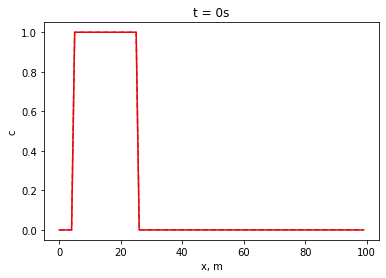

In [5]:
cfl = .9
dx = 1
dt = 1
c, x0 = cfl*dx/dt, 15 # advect left to right
# c, x0 = -cfl*dx/dt, 85 # advect right to left
x = np.arange(100)*dx
shape = "step"
# shape = "gaussian"
kw_init=dict(shape=shape, x0=x0)
u0 = init_shape(x, **kw_init)
plot_step(x, u0, c, 0,  dt, **kw_init)

## First-order upwind
Let $\mathcal{C}=c\Delta t/\Delta x$.
\begin{align}
u^{n+1}_i = u^{n}_i
- \mathcal{C}
\left(u^{n}_{i} - u^{n}_{i-1}\right).
\end{align}

Saving figs in figs_fou


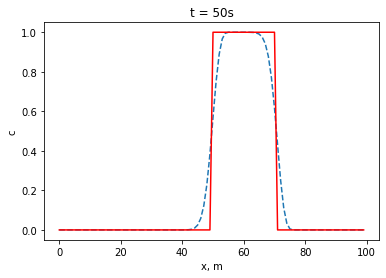

In [6]:
adv = Advect1D(dx, dt, scheme='first_order_upwind')
run(adv, u0, c, x, outdir="figs_fou", **kw_init)

Saving figs in figs_lf


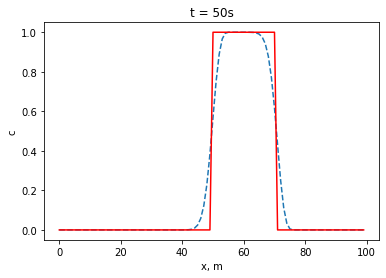

In [7]:
adv = Advect1D(dx, dt, scheme='lax_friedrichs')
run(adv, u0, c, x, outdir='figs_lf', **kw_init)

## Lax-Wendroff
Let $\mathcal{C}=c\Delta t/\Delta x$.
\begin{align}
u^{n+1}_i = u^{n}_i
- \frac{\mathcal{C}}{2}
\left(u^{n}_{i+1} - u^{n}_{i-1}\right)
+\frac{\mathcal{C}^2}{2}
\left(u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1}\right)
\end{align}

Saving figs in figs_lw


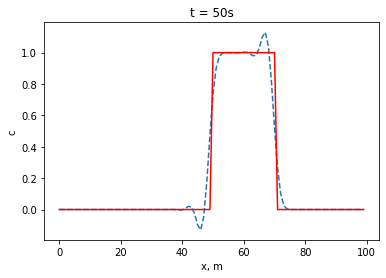

In [8]:
adv = Advect1D(dx, dt, scheme='lax_wendroff')
run(adv, u0, c, x, outdir='figs_lw', **kw_init)

Saving figs in figs_lw_vl


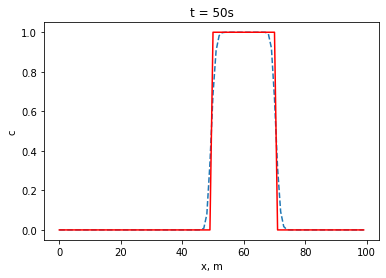

In [9]:
adv = Advect1D(dx, dt, scheme='lax_wendroff', limiter='van_leer')
run(adv, u0, c, x, outdir='figs_lw_vl', **kw_init)

Saving figs in figs_lw_sb


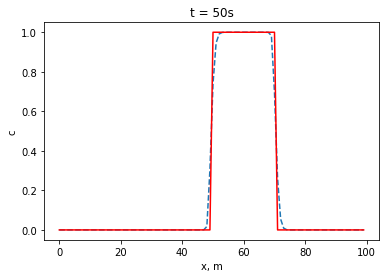

In [10]:
adv = Advect1D(dx, dt, scheme='lax_wendroff', limiter='superbee')
run(adv, u0, c, x, outdir='figs_lw_sb', **kw_init)